In [2]:
from tif2pngs import Tif2Pngs, ROOT
import os

# 分割原始 tif 文件
infer_dir = os.path.join(ROOT, 'data', 'infer')
result_file_path = os.path.join(ROOT, 'datasets', 'B', 'result.tif')
tif2pngs = Tif2Pngs(result_file_path, os.path.join(infer_dir, 'images'), inference=True, stride=64)
tif2pngs.process_tif()

100%|██████████| 322772/322772 [1:29:01<00:00, 60.42it/s]  


In [1]:
from tif2pngs import ROOT
import os
from segmentation_models_pytorch import Unet
import torch

model_path = os.path.join(ROOT, 'model', 'best_model_epoch_50_3c.pth')
model_config = {
    'model': Unet,
    'encoder_name': 'resnet34',
    'classes': 3,
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model_config['model'](
    encoder_name=model_config['encoder_name'],
    classes=model_config['classes'],
).to(device)

model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
pass

In [2]:
from SegmentationDataset import SegmentationDataset
from torch.utils.data import DataLoader
from torchvision import transforms as T

images_dir = os.path.join(ROOT, 'data', 'infer')

transform = T.Compose([
    T.ToTensor(),
])
infer_dataset = SegmentationDataset(root_dir=images_dir, transform=transform, inference=True)

In [3]:
import re
import numpy as np

images = infer_dataset.get_images()
max_x = 0
max_y = 0

for image in images:
    match = re.search(r'_(\d+)_(\d+)\.png', image)
    if match:
        x = int(match.group(1))
        y = int(match.group(2))
        if x > max_x:
            max_x = x
        if y > max_y:
            max_y = y

# 新建一个 ndarray
array = np.zeros((3, max_x + 256, max_y + 256), dtype=np.float16)

In [4]:
import numpy as np
import re

with torch.no_grad():
    for input_image, image_name in infer_dataset:
        tmp = input_image.unsqueeze(0).to(device)
        output = model(tmp)
        result = output.squeeze().cpu().numpy()
        # print(result.shape)
        # result = np.argmax(result, axis=0)
        # print(result.shape)
        # print(image_name)
        match = re.search(r'_(\d+)_(\d+)', image_name)
        if match:
            x = int(match.group(1))
            y = int(match.group(2))
            array[:, x:x + 256, y:y + 256] += result
        else:
            print(f"Error: {image_name} does not match the pattern")

        # break

In [5]:
# 保存 array 到 npy 文件
import time
file_name = f"submission_{int(time.time())}.npy"
np.save(file_name, array)
file_name

'submission_1732185988.npy'

In [1]:
import rasterio
import os
from tif2pngs import ROOT

result_file_path = os.path.join(ROOT, 'datasets', 'B', 'result.tif')
with rasterio.open(result_file_path) as src:
    meta = src.meta.copy()
    print(meta)
    pruned_shape = (meta['height'], meta['width'])


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 37677, 'height': 35068, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]'), 'transform': Affine(0.0626, 0.0, 264493.5783968877,
       0.0, -0.0626, 4512247.584260046)}


In [2]:
meta.update({
    'count': 1,
})

In [3]:
import numpy as np
# 从 npy 文件获取矩阵
array = np.load(f"submission_1732185988.npy")

In [4]:
array.shape

(3, 35264, 37888)

In [5]:
pruned_shape

(35068, 37677)

In [6]:
array = np.argmax(array, axis=0)

In [7]:
# 将 array 裁剪到与 result.tif 相同的大小
array = array[:pruned_shape[0], :pruned_shape[1]]

In [8]:
array.shape

(35068, 37677)

In [9]:
import time

output_path = os.path.join(ROOT, f'submission_{int(time.time())}.tif')

with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(array, 1)


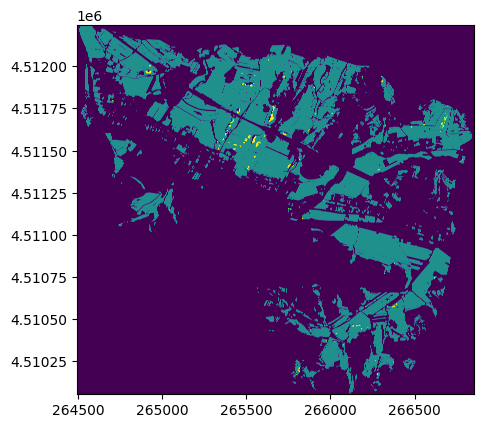

<Axes: >

In [10]:
from rasterio.plot import show

# 打开tif文件
ds_standard = rasterio.open(output_path)

show((ds_standard, 1))